In [6]:
import numpy as np 
from sympy import symbols, exp, integrate
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve
import scipy.constants as consts
from scipy.integrate import quad
import sys

In [7]:
df_Dwinelle = pd.read_csv('Spectrum_Dwinelle_Radiation_Project.csv')
df_Etcheverry = pd.read_csv('Spectrum_Etcheverry_Radiation_Project.csv')
df_Evans = pd.read_csv('Spectrum_Evans_Radiation_Project_Full.csv')
df_Hearst = pd.read_csv('Spectrum_Hearst_Radiation_Project.csv')
df_Moffit = pd.read_csv('Spectrum_Moffitt_Radiation_Project_Full.csv')
df_Waywest = pd.read_csv('Spectrum_WayWest_Radiation_Project_Full.csv')

df_Dwinelle = df_Dwinelle.iloc[-1]
df_Etcheverry = df_Etcheverry.iloc[-1]
df_Evans = df_Evans.iloc[-1]
df_Hearst = df_Hearst.iloc[-1]
df_Moffit = df_Moffit.iloc[-1]
df_Waywest = df_Waywest.iloc[-1]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, fsolve
from sympy import symbols, exp, integrate

def Location(location, exponential_range, gaussian_range):
    if location == 'Dwinelle':
        df_location = df_Dwinelle.iloc[exponential_range]
        df_location_gaussian = df_Dwinelle.iloc[gaussian_range]
        
        bins = df_Dwinelle.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Dwinelle)) * energy_per_bin
        plt.plot(calibrated_energy[exponential_range], df_Dwinelle[exponential_range], label = 'Energy Spectra Gathered from Detector')
    
    if location == 'Etcheverry':
        df_location = df_Etcheverry.iloc[exponential_range]
        df_location_gaussian = df_Etcheverry.iloc[gaussian_range]
    
        bins = df_Etcheverry.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Etcheverry)) * energy_per_bin
        plt.plot(calibrated_energy[exponential_range], df_Etcheverry[exponential_range], label = 'Energy Spectra Gathered from Detector')
    
    if location == 'Evans':
        df_location = df_Evans.iloc[exponential_range]
        df_location_gaussian = df_Evans.iloc[gaussian_range]
    
        bins = df_Evans.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Evans)) * energy_per_bin
        plt.plot(calibrated_energy[exponential_range], df_Evans[exponential_range], label = 'Energy Spectra Gathered from Detector')
    
    if location == 'Hearst':
        df_location = df_Hearst.iloc[exponential_range]
        df_location_gaussian = df_Hearst.iloc[gaussian_range]
    
        bins = df_Hearst.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Hearst)) * energy_per_bin
        plt.plot(calibrated_energy[exponential_range], df_Hearst[exponential_range], label = 'Energy Spectra Gathered from Detector')
    
    if location == 'Moffit':
        df_location = df_Moffit.iloc[exponential_range]
        df_location_gaussian = df_Moffit.iloc[gaussian_range]

        bins = df_Moffit.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Moffit)) * energy_per_bin
        plt.plot(calibrated_energy[exponential_range], df_Moffit[exponential_range], label = 'Energy Spectra Gathered from Detector')

    if location == 'Waywest':
        df_location = df_Waywest.iloc[exponential_range]
        df_location_gaussian = df_Waywest.iloc[gaussian_range]

        bins = df_Waywest.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Waywest)) * energy_per_bin
        plt.plot(calibrated_energy[exponential_range], df_Waywest[exponential_range], label = 'Energy Spectra Gathered from Detector')

    # Gaussian Fit
    gaussian_index = np.arange(len(df_location_gaussian))
    gaussian_values = df_location_gaussian.values.flatten()

    std = np.std(gaussian_values)
    mean = np.mean(gaussian_values)
    def gaussian(x, amplitude, mean, std):
        return amplitude * np.exp(-((x - mean) / std) ** 2 / 2)
    
    initial_guess = (1, mean, std)
    params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
    amplitude, mean, std = params

    plt.plot(calibrated_energy[gaussian_range], gaussian(gaussian_index, amplitude, mean, std), label = 'Gaussian Fit')

    # Exponential Fit
    exponential_index = np.arange(len(df_location))
    exponential_values = df_location.values.flatten()

    def exponential(x, a, b):
        return a * np.exp(-b * x)
    
    params, _ = curve_fit(exponential, exponential_index, exponential_values)
    a, b = params
   
    plt.plot(calibrated_energy[exponential_range], exponential(exponential_index, a, b), label = 'Exponential Fit')
    plt.yscale('log')

    # Intersection
    def intersection_function(x, amplitude, mean, std, a, b):
        return gaussian(x, amplitude, mean, std) - exponential(x, a, b)

    intersection_points = []
    for i in range(len(df_location)):
        intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
        intersection_point = int(intersection_point)
        intersection_points.append(intersection_point)

    intersection_points = np.array(intersection_points)
    intersection_points = intersection_points[intersection_points < len(calibrated_energy)]
    intersection_points = np.unique(intersection_points) 

    # Integration
    x = symbols('x')
    f_gaussian = amplitude * exp(-((x - mean) / std) ** 2 / 2)
    f_exponential = a * exp(-b * x)

    lower_bound = intersection_points[0]
    upper_bound = intersection_points[1]

    definite_integral_gaussian = integrate(f_gaussian, (x, lower_bound, upper_bound))   
    definite_integral_exponential = integrate(f_exponential, (x, lower_bound, upper_bound))
    definite_integral = definite_integral_gaussian - definite_integral_exponential
    print(definite_integral)
    print(f'definite integral = {np.ceil(definite_integral)} counts')   

    if definite_integral < 0:
        print('there are no counts for this isotope')
    
    plt.xlabel('Energy (keV)')
    plt.ylabel('Count Rate (CPM)')
    plt.title('Energy (keV) vs. Count Rate (CPM)')
    plt.legend()



$$\text{K-40}$$

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:93: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-346.592667204644 + 340.932358992413*sqrt(pi)
definite integral = 258 counts


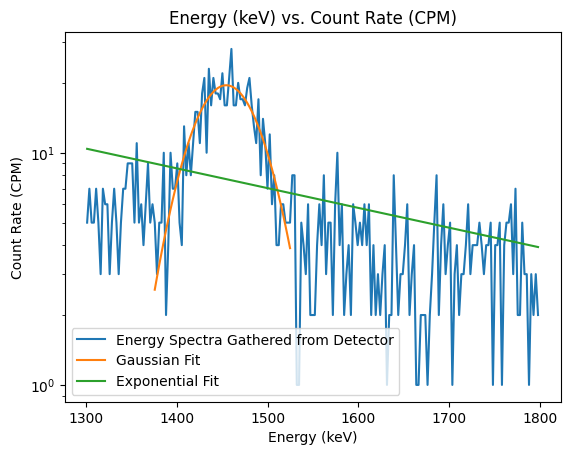

In [114]:
#Dwinelle
lower_energy_index = np.argmax(calibrated_energy >= 1375)
upper_energy_index = np.argmax(calibrated_energy >= 1525)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 1300))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1800))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Dwinelle', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

print()

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-640.846430423227 + 603.784877050446*sqrt(pi)
definite integral = 430 counts


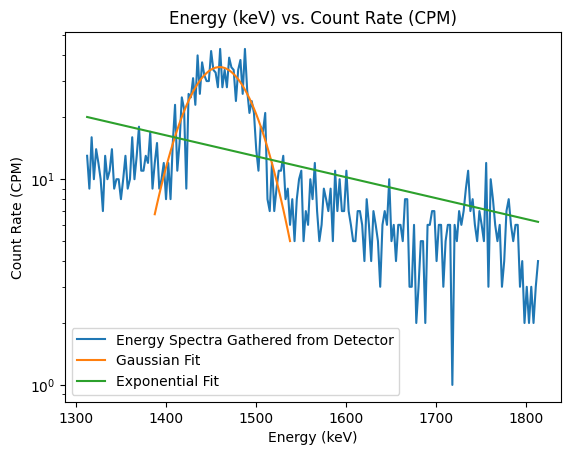

In [116]:
#Etcheverry
lower_energy_index = np.argmax(calibrated_energy >= 1375)
upper_energy_index = np.argmax(calibrated_energy >= 1525)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 1300))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1800))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Etcheverry', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2040919084.py:107: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-3098.62037696072 + 2746.55992913611*sqrt(pi)
definite integral = 1770 counts


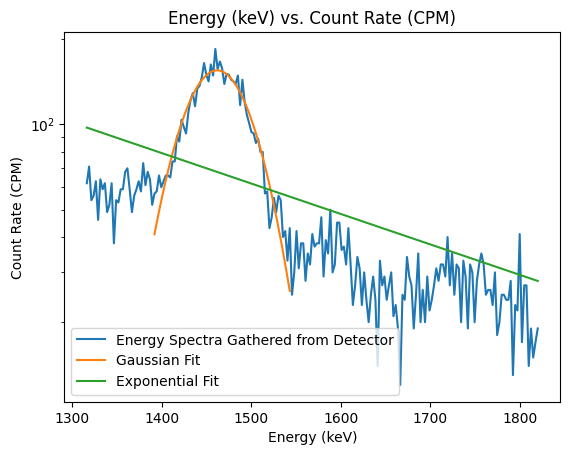

In [119]:
#Evans
lower_energy_index = np.argmax(calibrated_energy >= 1375)
upper_energy_index = np.argmax(calibrated_energy >= 1525)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 1300))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1800))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Evans', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3684168643.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3684168643.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3684168643.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-759.082000559921 + 698.399895908549*sqrt(pi)
definite integral = 479 counts


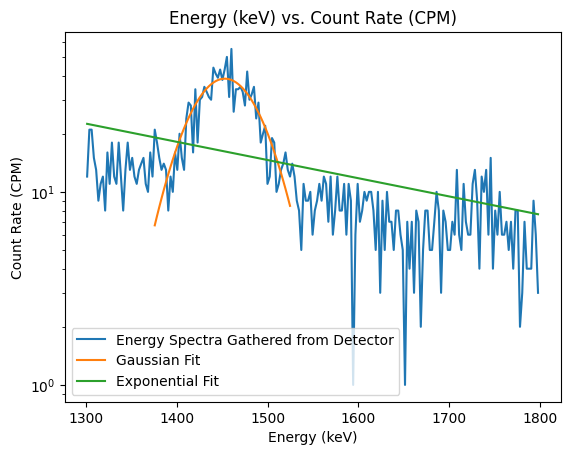

In [122]:
#Hearst
lower_energy_index = np.argmax(calibrated_energy >= 1375)
upper_energy_index = np.argmax(calibrated_energy >= 1525)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 1300))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1800))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Hearst', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:93: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-885.319020891625 + 794.147996113287*sqrt(pi)
definite integral = 523 counts


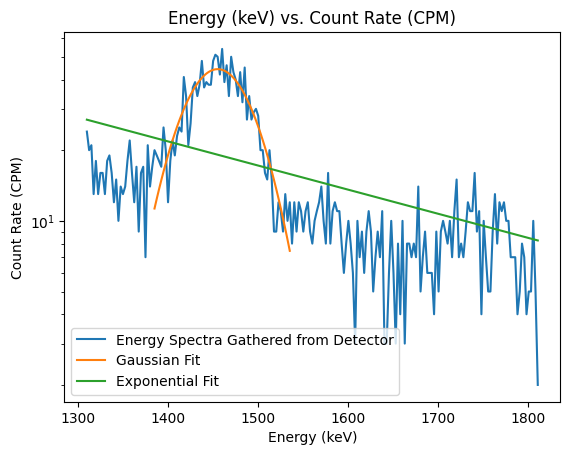

In [127]:
#Moffit
lower_energy_index = np.argmax(calibrated_energy >= 1375)
upper_energy_index = np.argmax(calibrated_energy >= 1525)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 1300))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1800))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Moffit', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\3867616141.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-313.856284064904 + 272.393466160425*sqrt(pi)
definite integral = 169 counts


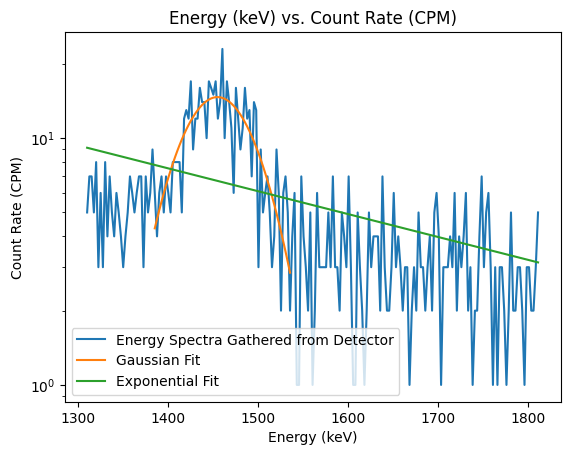

In [128]:
#Waywest
lower_energy_index = np.argmax(calibrated_energy >= 1375)
upper_energy_index = np.argmax(calibrated_energy >= 1525)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 1300))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1800))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Waywest', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

$$\text{U-238}$$

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-54.7354554302249 + 31.010444785224*sqrt(pi)
definite integral = 1 counts


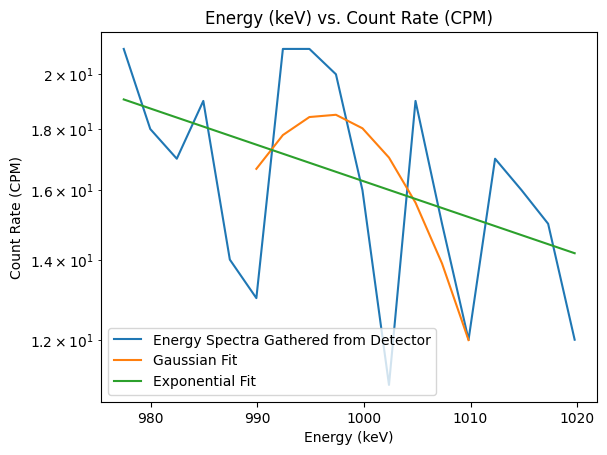

In [151]:
#Dwinelle
lower_energy_index = np.argmax(calibrated_energy >= 989)
upper_energy_index = np.argmax(calibrated_energy >= 1012)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 975))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1020))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Dwinelle', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


-107.061687732768 + 60.7249951772795*sqrt(pi)
definite integral = 1 counts


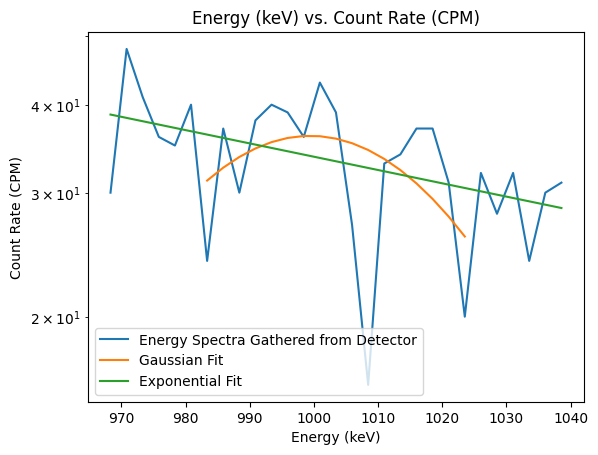

In [171]:
#Etcheverry
lower_energy_index = np.argmax(calibrated_energy >= 974)
upper_energy_index = np.argmax(calibrated_energy >= 1015)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 960))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1030))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Etcheverry', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

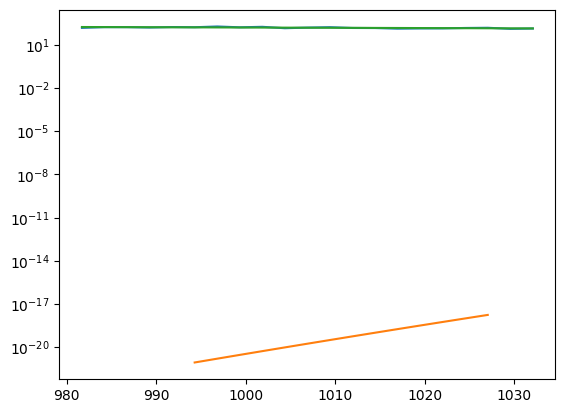

In [225]:
#Evans
lower_energy_index = np.argmax(calibrated_energy >= 980)
upper_energy_index = np.argmax(calibrated_energy >= 1015)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 970))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1020))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Evans', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-161.20840234467 + 95.1996452854489*sqrt(pi)
definite integral = 8 counts


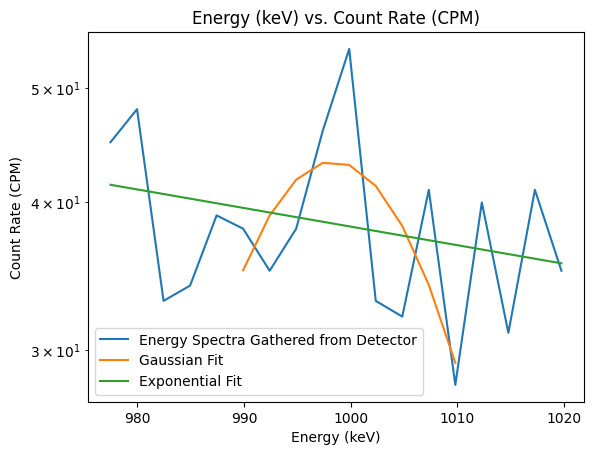

In [183]:
#Hearst
lower_energy_index = np.argmax(calibrated_energy >= 989)
upper_energy_index = np.argmax(calibrated_energy >= 1012)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 975))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1020))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Hearst', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


-206.499217833052 + 118.364069125413*sqrt(pi)
definite integral = 4 counts


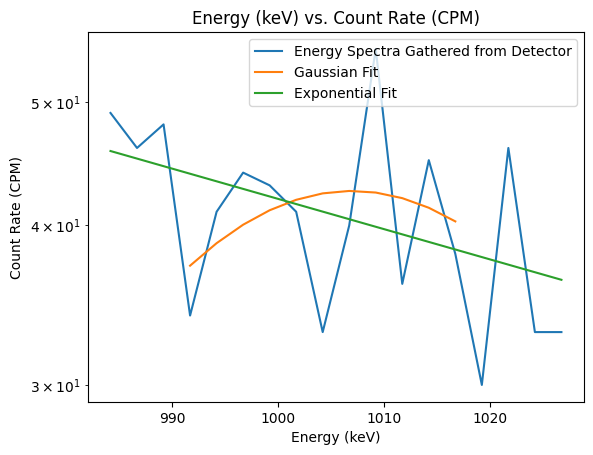

In [223]:
#Moffit
lower_energy_index = np.argmax(calibrated_energy >= 983)
upper_energy_index = np.argmax(calibrated_energy >= 1010)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 975))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1020))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Moffit', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))


-14.8918781888104 + 8.33884615388223*sqrt(pi)
definite integral = 0 counts
there are no counts for this isotope


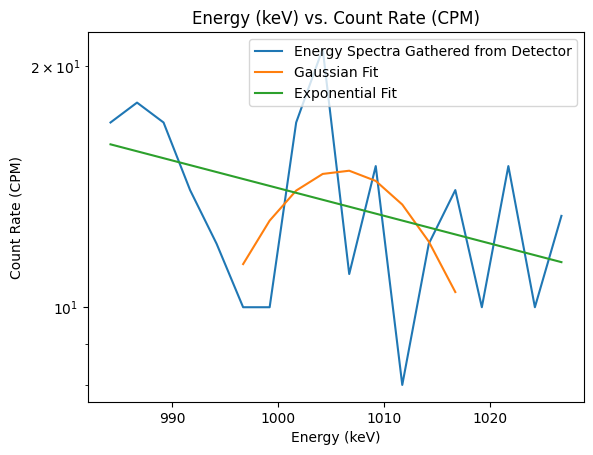

In [226]:
#Waywest
lower_energy_index = np.argmax(calibrated_energy >= 989)
upper_energy_index = np.argmax(calibrated_energy >= 1012)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 975))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 1020))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Waywest', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

$$\text{Iodine-131}$$

This section has all errors because a gaussian cannot be formed amongst the selected. This is because there isn't a prescence of a distinct peak such that the fit can detect unlike the K-40. Therefore, an error in the code means that only the exponential fit is eligible of being graph, in which symbolizes the background radiation. The resulting error thus indicates that there are 0 counts for the code.  

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

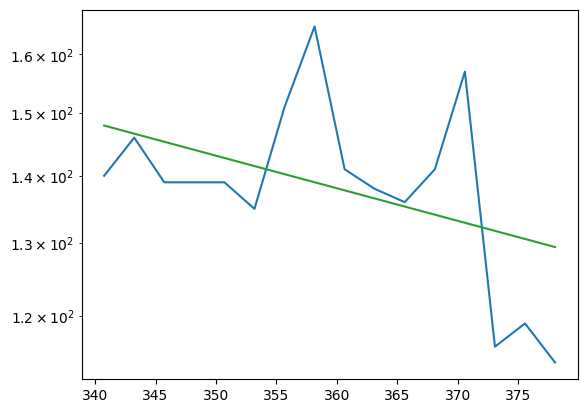

In [234]:
#Dwinelle
lower_energy_index = np.argmax(calibrated_energy >= 360)
upper_energy_index = np.argmax(calibrated_energy >= 367)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 340))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 380))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Dwinelle', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

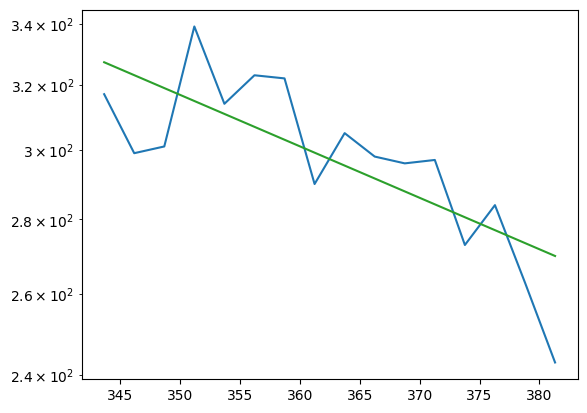

In [238]:
#Etcheverry
lower_energy_index = np.argmax(calibrated_energy >= 361)
upper_energy_index = np.argmax(calibrated_energy >= 370)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 340))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 380))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Etcheverry', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

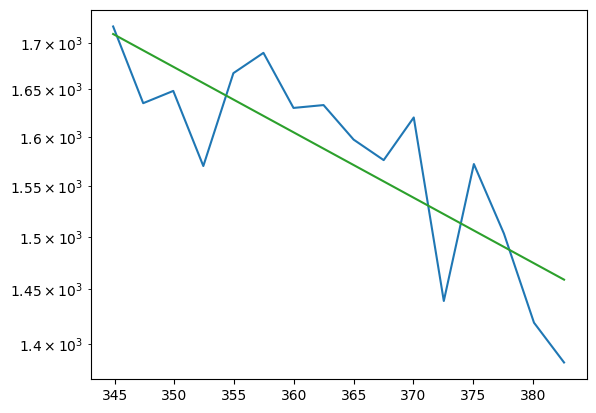

In [252]:
#Evans
lower_energy_index = np.argmax(calibrated_energy >= 360)
upper_energy_index = np.argmax(calibrated_energy >= 366)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 340))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 380))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Evans', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

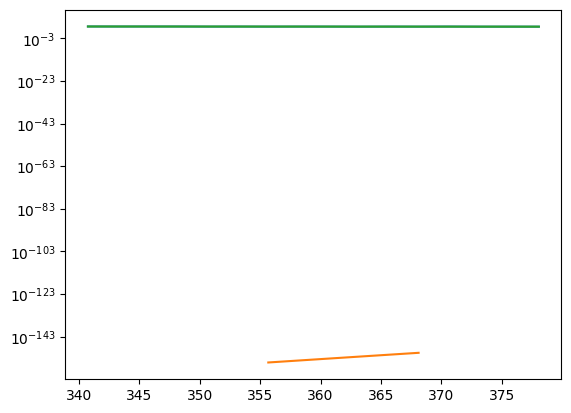

In [241]:
#Hearst
lower_energy_index = np.argmax(calibrated_energy >= 355)
upper_energy_index = np.argmax(calibrated_energy >= 370)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 340))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 380))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Hearst', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

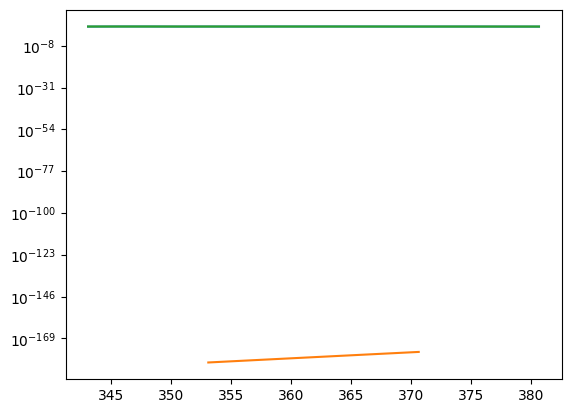

In [243]:
#Moffit
lower_energy_index = np.argmax(calibrated_energy >= 350)
upper_energy_index = np.argmax(calibrated_energy >= 370)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 340))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 380))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Moffit', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:107: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  intersection_point = fsolve(intersection_function, i, args=(amplitude, mean, std, a, b))
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

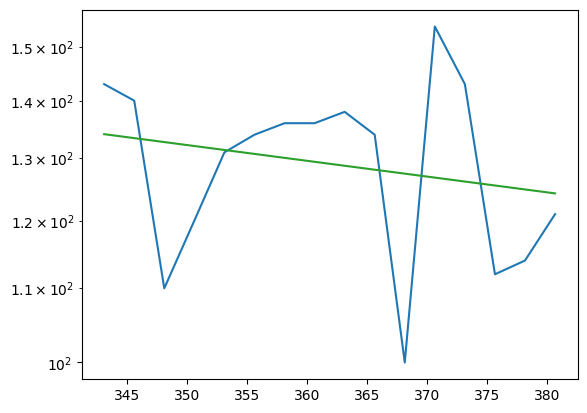

In [249]:
#Waywest
lower_energy_index = np.argmax(calibrated_energy >= 357)
upper_energy_index = np.argmax(calibrated_energy >= 365)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 340))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 380))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Waywest', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

$$\text{Radon-222}$$

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 1 is out of bounds for axis 0 with size 1

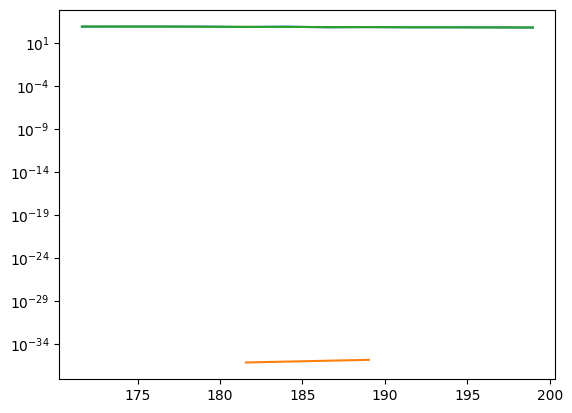

In [253]:
#Dwinelle
lower_energy_index = np.argmax(calibrated_energy >= 180)
upper_energy_index = np.argmax(calibrated_energy >= 190)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 170))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 200))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Dwinelle', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 1 is out of bounds for axis 0 with size 1

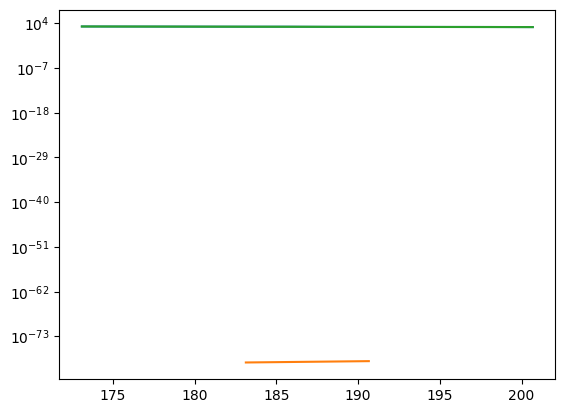

In [254]:
#Etcheverry
lower_energy_index = np.argmax(calibrated_energy >= 180)
upper_energy_index = np.argmax(calibrated_energy >= 190)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 170))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 200))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Etcheverry', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

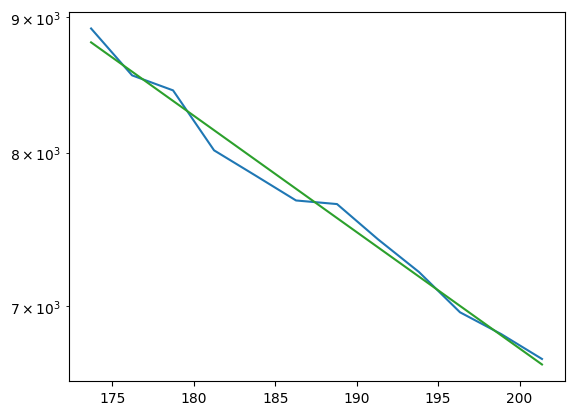

In [255]:
#Evans
lower_energy_index = np.argmax(calibrated_energy >= 180)
upper_energy_index = np.argmax(calibrated_energy >= 190)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 170))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 200))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Evans', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

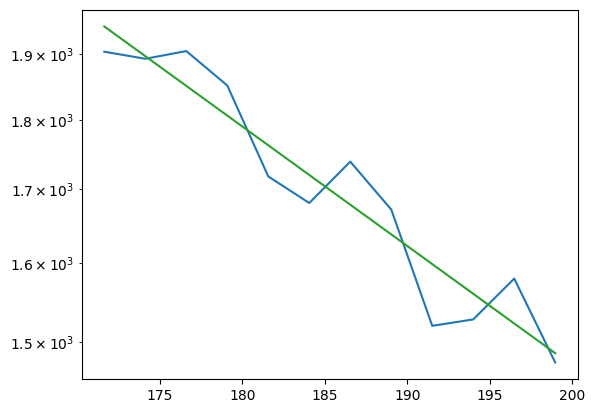

In [256]:
#Hearst
lower_energy_index = np.argmax(calibrated_energy >= 180)
upper_energy_index = np.argmax(calibrated_energy >= 190)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 170))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 200))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Hearst', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 0 is out of bounds for axis 0 with size 0

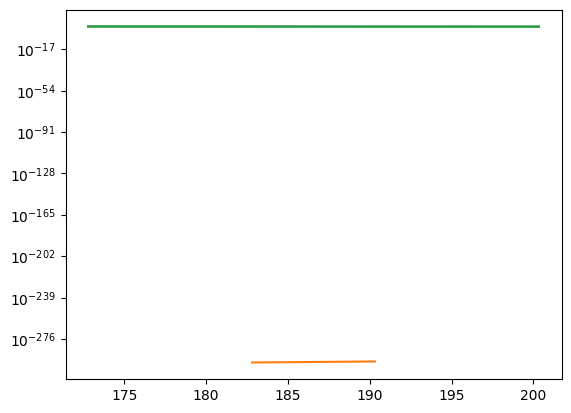

In [257]:
#Moffit
lower_energy_index = np.argmax(calibrated_energy >= 180)
upper_energy_index = np.argmax(calibrated_energy >= 190)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 170))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 200))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Moffit', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:83: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(gaussian, gaussian_index, gaussian_values, p0=initial_guess, maxfev = 1000000)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:93: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
C:\Users\seanz\AppData\Local\Temp\ipykernel_11880\2051018667.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection_point = int(intersection_point)


IndexError: index 1 is out of bounds for axis 0 with size 1

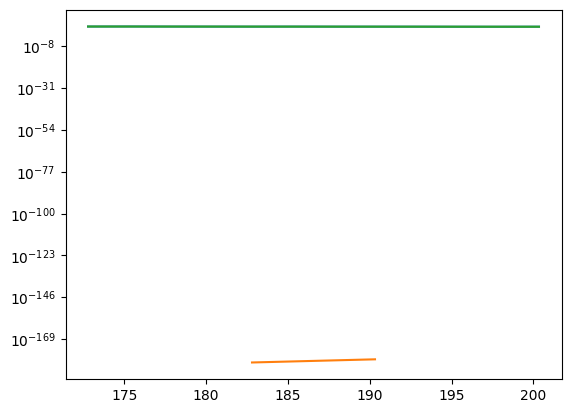

In [258]:
#Waywest
lower_energy_index = np.argmax(calibrated_energy >= 180)
upper_energy_index = np.argmax(calibrated_energy >= 190)

# Expand the range for the exponential fit to include more points
lower_energy_index_exponential = max(0, np.argmax(calibrated_energy >= 170))  # Ensure it doesn't go below 0
upper_energy_index_exponential = min(len(calibrated_energy), np.argmax(calibrated_energy >= 200))  # Ensure it doesn't exceed the length

# Call the Location function with the adjusted energy range indices
Location('Waywest', exponential_range=slice(lower_energy_index_exponential, upper_energy_index_exponential), gaussian_range=slice(lower_energy_index, upper_energy_index))

In [13]:
def Activity(location, desired_energy):
    if location == 'Dwinelle':
        # Assuming you have already defined bins, bin, energy_per_bin, and calibrated_energy
        bins = df_Dwinelle.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Dwinelle)) * energy_per_bin

        closest_index = np.abs(calibrated_energy - desired_energy).argmin()
        index_in_df = closest_index
        value_at_desired_energy = df_Dwinelle.iloc[index_in_df]

        value_at_desired_energy = value_at_desired_energy * desired_energy * 1.602e-16 * 60 * 24 * 365 / .24
        value_at_desired_energy = value_at_desired_energy * 1e6
        print("Value in df_Dwinelle at desired energy:", value_at_desired_energy)
    if location == 'Etcheverry':
        # Assuming you have already defined bins, bin, energy_per_bin, and calibrated_energy
        bins = df_Etcheverry.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Etcheverry)) * energy_per_bin

        closest_index = np.abs(calibrated_energy - desired_energy).argmin()
        index_in_df = closest_index
        value_at_desired_energy = df_Etcheverry.iloc[index_in_df]

        value_at_desired_energy = value_at_desired_energy * desired_energy * 1.602e-16 * 60 * 24 * 365 / .24
        value_at_desired_energy = value_at_desired_energy * 1e6
        print("Value in df_Etcheverry at desired energy:", value_at_desired_energy)


    if location == 'Evans':
        # Assuming you have already defined bins, bin, energy_per_bin, and calibrated_energy
        bins = df_Evans.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Evans)) * energy_per_bin

        closest_index = np.abs(calibrated_energy - desired_energy).argmin()
        index_in_df = closest_index
        value_at_desired_energy = df_Evans.iloc[index_in_df]
        
        value_at_desired_energy = value_at_desired_energy * desired_energy * 1.602e-16 * 60 * 24 * 365 / .24
        value_at_desired_energy = value_at_desired_energy * 1e6
        print("Value in df_Etcheverry at desired energy:", value_at_desired_energy)
    if location == 'Hearst':
        # Assuming you have already defined bins, bin, energy_per_bin, and calibrated_energy
        bins = df_Hearst.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Hearst)) * energy_per_bin

        closest_index = np.abs(calibrated_energy - desired_energy).argmin()
        index_in_df = closest_index
        value_at_desired_energy = df_Hearst.iloc[index_in_df]

        value_at_desired_energy = value_at_desired_energy * desired_energy * 1.602e-16 * 60 * 24 * 365 / .24
        value_at_desired_energy = value_at_desired_energy * 1e6
        print("Value in df_Etcheverry at desired energy:", value_at_desired_energy)
    if location == 'Moffit':
        # Assuming you have already defined bins, bin, energy_per_bin, and calibrated_energy
        bins = df_Moffit.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Moffit)) * energy_per_bin

        closest_index = np.abs(calibrated_energy - desired_energy).argmin()
        index_in_df = closest_index
        value_at_desired_energy = df_Moffit.iloc[index_in_df]

        value_at_desired_energy = value_at_desired_energy * desired_energy * 1.602e-16 * 60 * 24 * 365 / .24
        value_at_desired_energy = value_at_desired_energy * 1e6
        print("Value in df_Etcheverry at desired energy:", value_at_desired_energy)
    if location == 'Waywest':
        # Assuming you have already defined bins, bin, energy_per_bin, and calibrated_energy
        bins = df_Waywest.iloc[550:620]
        bin = np.argmax(bins)
        bin = bin + 550
        energy_per_bin = 1460 / bin
        calibrated_energy = np.arange(0, len(df_Waywest)) * energy_per_bin

        closest_index = np.abs(calibrated_energy - desired_energy).argmin()
        index_in_df = closest_index
        value_at_desired_energy = df_Waywest.iloc[index_in_df]

        value_at_desired_energy = value_at_desired_energy * desired_energy * 1.602e-16 * 60 * 24 * 365 / .24
        value_at_desired_energy = value_at_desired_energy * 1e6
        print("Value in df_Etcheverry at desired energy:", value_at_desired_energy)

In [35]:
Activity('Etcheverry', np.sqrt(1001))

Value in df_Etcheverry at desired energy: 0.011100017547114238
